In [194]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans
from scipy import stats
from nltk.corpus import stopwords
import sklearn.feature_extraction.text as text
from nltk.tokenize import word_tokenize 
import re

In [221]:
plt.style.use('fivethirtyeight')

In [195]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [196]:
clust_df = pd.read_csv('/Users/gabrieltaylor/Python/STAT542/STAT542/gabet/clust_df.csv', index_col = 0)

# Supervised Task

In [197]:
sup_df = clust_df.join(df[['additives', 'nutrition-score-fr_100g']]).dropna()

In [198]:
sup_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,additives,nutrition-score-fr_100g
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,5,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0.0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,3,[ cranberries -> en:cranberries ] [ sugar -...,8.0
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,3,[ apricots -> en:apricots ] [ sulfur-dioxid...,8.0
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,[ wheat-flour -> en:wheat-flour ] [ flour -...,18.0
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,[ enriched-wheat-flour -> en:enriched-wheat-f...,14.0


## Is there a clear ranking of nutrition scores by cluster?

In [199]:
ranks = pd.DataFrame(sup_df.groupby('clust').mean()['nutrition-score-fr_100g']).sort_values('nutrition-score-fr_100g')
ranks.sort_values("nutrition-score-fr_100g")

,nutrition-score-fr_100g
clust,
5,0.334542
1,1.170208
6,5.114522
4,8.904300
3,13.166827
2,20.422587
0,21.349800


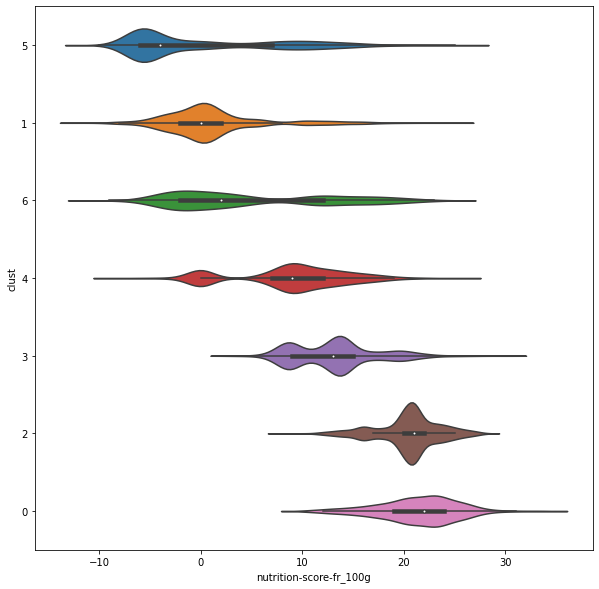

In [200]:
plt.figure(figsize = (10, 10))
sns.violinplot(data=sup_df, x = 'nutrition-score-fr_100g', y="clust", orient="h", order = [5, 1, 6, 4, 3, 2, 0])
plt.show()

Yes, there is clearly a ranking of nutrition scores by cluster.

## How well can clusters alone predict nutrition score?

First, we will make this a supremely easy task by splitting the nutrition score into binary categories. 

In [201]:
sup_df['nutrition-score-fr_100g'].describe()

count    12222.000000
mean         7.449435
std          9.623551
min        -12.000000
25%         -1.000000
50%          6.000000
75%         16.000000
max         34.000000
Name: nutrition-score-fr_100g, dtype: float64

In [202]:
sup_df['new_score'] = list(map(lambda x : 1 if x > 6 else 0, sup_df['nutrition-score-fr_100g']))
sup_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,additives,nutrition-score-fr_100g,new_score
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,5,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0.0,0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,3,[ cranberries -> en:cranberries ] [ sugar -...,8.0,1
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,3,[ apricots -> en:apricots ] [ sulfur-dioxid...,8.0,1
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,[ wheat-flour -> en:wheat-flour ] [ flour -...,18.0,1
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,[ enriched-wheat-flour -> en:enriched-wheat-f...,14.0,1


In [203]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [204]:
X = sup_df['clust']
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [205]:
model = XGBClassifier()
model.fit(X_train.values.reshape(-1, 1), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [206]:
y_pred = model.predict(X_test.values.reshape(-1, 1))
accuracy_score(y_test, y_pred)

0.8638036809815951

85% accuracy is not bad. Now, how can we use the clusters and text information to predict nutrition score?

# In case using cluster info is cheating, lets try regular TF_IDF

### EDIT: it is

In [207]:
sup_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,additives,nutrition-score-fr_100g,new_score
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,5,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,0.0,0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,3,[ cranberries -> en:cranberries ] [ sugar -...,8.0,1
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,3,[ apricots -> en:apricots ] [ sulfur-dioxid...,8.0,1
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,[ wheat-flour -> en:wheat-flour ] [ flour -...,18.0,1
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,[ enriched-wheat-flour -> en:enriched-wheat-f...,14.0,1


### Clean additives

In [208]:
clean_additives = lambda s: re.sub(r'[^a-z- ]+' , " ", s.lower().replace("en:","").replace("->","")).strip()
sup_df["additives"] = sup_df["additives"].apply(clean_additives)

In [209]:
sup_df.head()

,ingredients_text,carbohydrates_100g,fiber_100g,sugars_100g,proteins_100g,fat_100g,saturated-fat_100g,clust,additives,nutrition-score-fr_100g,new_score
2,peanuts wheat-flour sugar rice-flour tapioca-s...,1.119606,1.255472,0.371259,0.859435,0.137917,-0.700412,5,peanuts peanuts wheat-flour wheat-flou...,0.0,0
148,cranberries sugar sunflower-oil,1.896869,2.083100,3.082730,-1.065403,-0.795579,-0.700412,3,cranberries cranberries sugar sugar ...,8.0,1
149,apricots sulfur-dioxide,1.181114,1.369627,2.295565,-0.795968,-0.795579,-0.700412,3,apricots apricots sulfur-dioxide e ...,8.0,1
200,wheat-flour butter cream water yeast sugar sa...,0.550919,-0.399784,-0.332580,-0.225846,0.086695,0.767782,5,wheat-flour wheat-flour flour flour ...,18.0,1
201,enriched-wheat-flour wheat-flour malted-barley...,0.656066,-0.513939,0.819560,-0.367029,0.027110,-0.177571,5,enriched-wheat-flour enriched-wheat-flour ...,14.0,1


### TF-IDF Additives

In [210]:
my_stop_words = set( stopwords.words('english')+ \
                    ['de', 'contains', 's', 'et', 'of', 'en', "fr",'less', 'p', 'exists', 'following', 'ok'])

In [211]:
### Instantiate
vectorizer = text.TfidfVectorizer(strip_accents="unicode",stop_words=my_stop_words, \
                                  ngram_range=(1,1),max_features=30, \
                                  encoding="utf-8", token_pattern=r"(?u)\S\S+")

### Fit 
vectors = vectorizer.fit_transform(sup_df["additives"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

feature_names = ["ADD:" + fn for fn in feature_names]
df_additive_features = pd.DataFrame(dense, columns=feature_names)

df_additive_features.head()

,ADD:--,ADD:acid,ADD:almonds,ADD:butter,ADD:cheese-culture,ADD:citric-acid,ADD:corn-syrup,ADD:cream,ADD:culture,ADD:enzymes,...,ADD:salt,ADD:sea-salt,ADD:semolina,ADD:soy-lecithin,ADD:starch,ADD:sugar,ADD:syrup,ADD:thiamin-mononitrate,ADD:water,ADD:wheat-flour
0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.294725,0.0,0.0,0.0,0.671666,0.194167,0.0,0.0,0.198986,0.306027
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.619826,0.0,0.0,0.000000,0.000000
2,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0.106418,0.000000,0.0,0.432528,0.0,0.0,0.0,0.462793,0.0,0.346258,...,0.195576,0.0,0.0,0.0,0.000000,0.257694,0.0,0.0,0.264089,0.406151
4,0.167177,0.204148,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.233395,0.134941,0.0,0.0,0.138290,0.425361


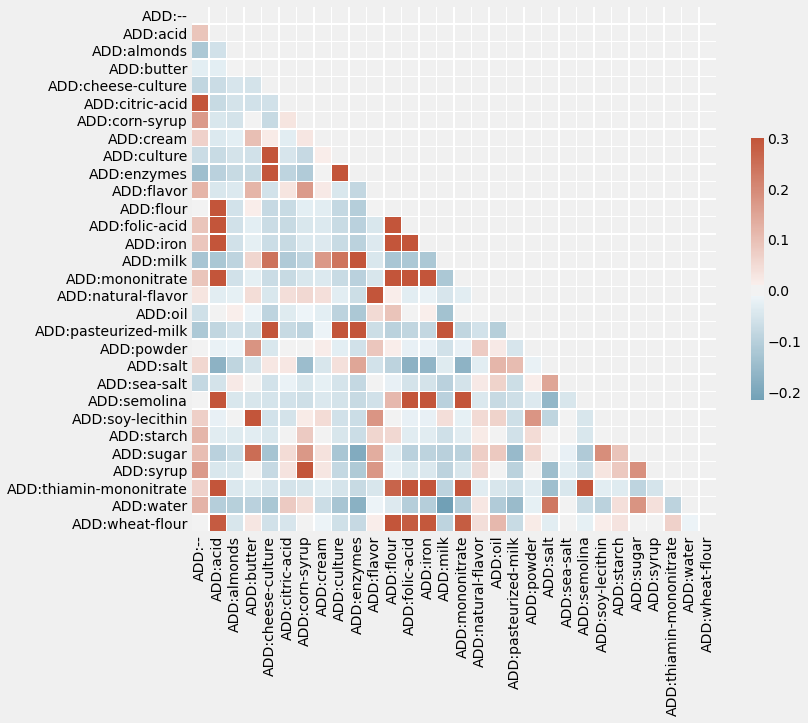

In [222]:
# Compute the correlation matrix
corr = df_additive_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### TF-IDF Ingredients

In [215]:
### Instantiate
vectorizer = text.TfidfVectorizer(strip_accents="unicode",stop_words=my_stop_words, \
                                  ngram_range=(1,1),max_features=30, \
                                  encoding="utf-8", token_pattern=r"(?u)\S\S+")

### Fit 
vectors = vectorizer.fit_transform(sup_df["ingredients_text"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()

feature_names = ["ING:" + fn for fn in feature_names]
df_ingre_features = pd.DataFrame(dense, columns=feature_names)

df_ingre_features

,ING:almonds,ING:cheese-culture,ING:citric-acid,ING:cocoa-butter,ING:corn,ING:corn-syrup,ING:cream,ING:dextrose,ING:enzymes,ING:ferrous-sulfate,...,ING:sea-salt,ING:semolina,ING:soy-lecithin,ING:spices,ING:sugar,ING:thiamin-mononitrate,ING:thiamine-mononitrate,ING:water,ING:wheat,ING:wheat-flour
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.260082,0.0,0.000000,0.267977,0.511788,0.443854
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.554896,0.0,0.411416,0.0,...,0.0,0.0,0.0,0.000000,0.304961,0.0,0.000000,0.314219,0.000000,0.520445
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.218663,0.0,0.395347,0.225301,0.000000,0.373168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12217,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
12218,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
12219,0.0,0.0,0.544436,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.682176,0.380248,0.0,0.000000,0.000000,0.000000,0.000000
12220,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


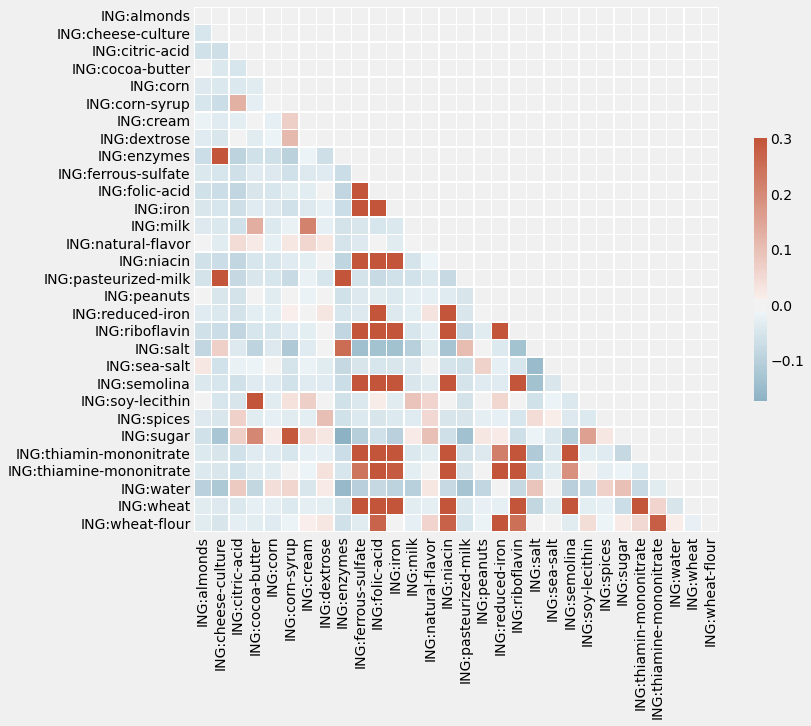

In [223]:
# Compute the correlation matrix
corr = df_ingre_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Concatenate 

In [217]:
df_feats = pd.concat([df_additive_features, df_ingre_features], axis=1)
df_feats = df_feats.drop(["ADD:--"], axis=1) # drop this, it's a garbage attribute

In [218]:
df_feats

,ADD:acid,ADD:almonds,ADD:butter,ADD:cheese-culture,ADD:citric-acid,ADD:corn-syrup,ADD:cream,ADD:culture,ADD:enzymes,ADD:flavor,...,ING:sea-salt,ING:semolina,ING:soy-lecithin,ING:spices,ING:sugar,ING:thiamin-mononitrate,ING:thiamine-mononitrate,ING:water,ING:wheat,ING:wheat-flour
0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.260082,0.0,0.000000,0.267977,0.511788,0.443854
1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.432528,0.0,0.000000,0.0,0.462793,0.0,0.346258,0.00000,...,0.0,0.0,0.0,0.000000,0.304961,0.0,0.000000,0.314219,0.000000,0.520445
4,0.204148,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.20509,...,0.0,0.0,0.0,0.000000,0.218663,0.0,0.395347,0.225301,0.000000,0.373168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12217,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
12218,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
12219,0.000000,0.0,0.000000,0.0,0.386262,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.682176,0.380248,0.0,0.000000,0.000000,0.000000,0.000000
12220,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


## Truncated SVD

In [219]:
from sklearn.decomposition import TruncatedSVD
X = df_feats
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=69)
svd.fit(X)

TruncatedSVD(n_components=30, n_iter=7, random_state=69)

In [220]:
svd.explained_variance_ratio_.sum()

0.9653924264907495

Since 97% of the variance is still explained with only 30 features (probably because additives is dependent on ingredients), we can proceed with only 30 features.

In [76]:
X_new = svd.transform(X)

# Classification

In [122]:
X = X_new
y = sup_df['new_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)
X_train.shape

(10388, 30)

## Logistic Regression with L1

In [123]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon

LR = LogisticRegression(penalty = "l1", max_iter=100, tol=1e-4, random_state=69, solver = 'saga')

dist = {"C" : expon()}

clf = RandomizedSearchCV(LR, dist, random_state=69)
search = clf.fit(X_train, y_train)

In [124]:
search.best_params_

{'C': 0.11090595621397231}

In [125]:
best_LR = search.best_estimator_

In [126]:
y_pred = best_LR.predict(X_train)
accuracy_score(y_train, y_pred)

0.8165190604543704

In [127]:
y_pred = best_LR.predict(X_test)
accuracy_score(y_test, y_pred)

0.806979280261723

## Random Forest

## Tuning

We use a randomized search with cross-validation for tuning our parameters

In [91]:
from sklearn.model_selection import RandomizedSearchCV

In [128]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [153]:
dist = {'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4)}

RF = RandomForestClassifier(random_state=69)

clf = RandomizedSearchCV(RF, dist, cv = 3, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [154]:
search.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 702}

In [155]:
best_RF = search.best_estimator_

In [157]:
y_pred = best_RF.predict(X_train)
accuracy_score(y_train, y_pred)

0.8828455910666153

In [158]:
y_pred = best_RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.8527808069792803

## XGBoost

In [162]:
from scipy.stats import uniform

In [166]:
dist = {'eta' : uniform(0.01, 0.1), 
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10)}

XGB = XGBClassifier()

clf = RandomizedSearchCV(XGB, dist, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [167]:
search.best_params_

{'eta': 0.045025252522341144, 'max_depth': 7, 'n_estimators': 661}

In [168]:
best_XGB = search.best_estimator_

In [169]:
y_pred = best_XGB.predict(X_train)
accuracy_score(y_train, y_pred)

0.8949749711205237

In [170]:
y_pred = best_XGB.predict(X_test)
accuracy_score(y_test, y_pred)

0.85659760087241

# Regression

In [171]:
X = X_new
y = sup_df['nutrition-score-fr_100g']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)
X_train.shape

(10388, 30)

## LASSO

## Tuning

We use a randomized search with cross-validation for tuning our parameters

In [172]:
from sklearn.model_selection import RandomizedSearchCV

In [174]:
from sklearn.linear_model import Lasso
from scipy.stats import expon

lasso = Lasso(max_iter=1000, tol=1e-4, random_state=69, selection="random")
dist = {"alpha" : expon()}

clf = RandomizedSearchCV(lasso, dist, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [175]:
search.best_params_

{'alpha': 0.06023922086460815}

In [176]:
best_lasso = search.best_estimator_

In [177]:
y_pred = best_lasso.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

6.225150080599127

In [178]:
y_pred = best_lasso.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

6.000567092486989

## Random Forest

In [179]:
from sklearn.ensemble import RandomForestRegressor

In [182]:
dist = {'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4)}

RF = RandomForestRegressor(random_state=69)

clf = RandomizedSearchCV(RF, dist, cv = 3, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [183]:
search.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 702}

In [184]:
best_RF = search.best_estimator_

In [186]:
y_pred = best_RF.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

4.677189438758958

In [187]:
y_pred = best_RF.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4.996265438544345

## XGBoost

In [189]:
dist = {'eta' : uniform(0.01, 0.1),
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10)}

XGB = XGBRegressor()

clf = RandomizedSearchCV(XGB, dist, random_state=69, n_iter = 10)
search = clf.fit(X_train, y_train)

In [190]:
y_pred = model.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

4.177898101369332

In [191]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

4.884057214208349